In [2]:
!pip install -q transformers torch pandas seaborn matplotlib tqdm

In [4]:
import json
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from tqdm.notebook import tqdm
from pathlib import Path
from google.colab import drive

drive.mount('/content/drive')
DATASET_PATH = Path("/content/drive/MyDrive/TFG/titles_data.jsonl")
MODEL_ID = "gpt2"

# Asegurar reproducibilidad
torch.manual_seed(42)

Mounted at /content/drive


In [5]:
def calculate_perplexity(text, model, tokenizer, device):
    """Calcula la perplejidad de un texto usando GPT-2."""
    if not isinstance(text, str) or len(text.strip()) < 10:
        return None

    # Truncamiento explícito a 512 para eficiencia en Colab (T4 GPU)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
    input_ids = inputs["input_ids"]

    # Evitar secuencias vacías tras el truncamiento
    if input_ids.shape[1] == 0:
        return None

    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss

    return torch.exp(loss).item()

[*] Cargando dataset...
[*] Dispositivo detectado: CUDA


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

[*] Procesando inferencia...


Calculando PPL:   0%|          | 0/1638 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


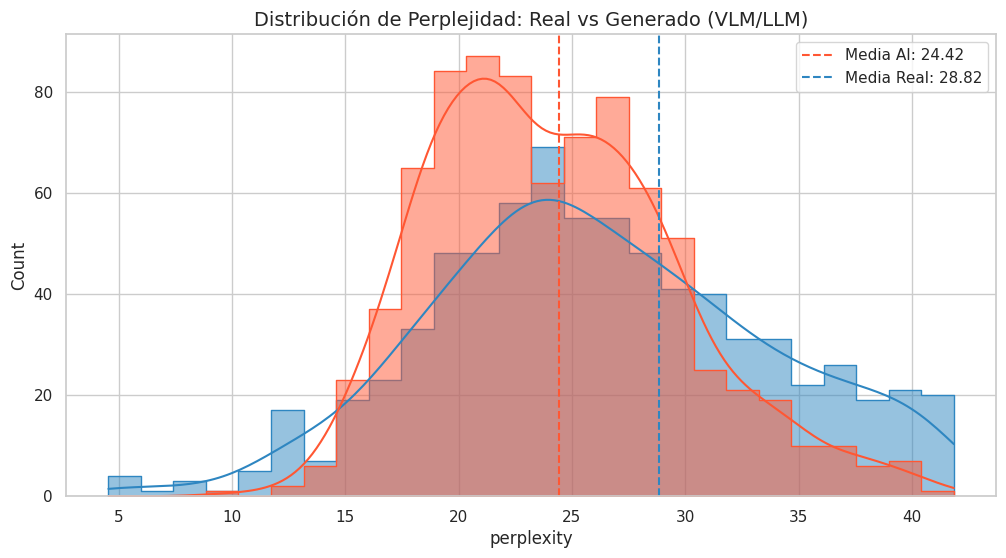

[+] Archivo guardado como: titles_dataset_with_perplexity.csv


In [6]:
# 1. Cargar Datos
if not DATASET_PATH.exists():
    print(f"⚠️ Error: Sube el archivo {DATASET_PATH} a la carpeta lateral de Colab.")
else:
    print(f"[*] Cargando dataset...")
    with open(DATASET_PATH, 'r', encoding='utf-8') as f:
        data = [json.loads(line) for line in f]

    df = pd.DataFrame(data)
    df['label'] = df['is_real'].map({1: "Real", 0: "AI"})

    # 2. Configurar Modelo
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"[*] Dispositivo detectado: {device.upper()}")

    tokenizer = GPT2Tokenizer.from_pretrained(MODEL_ID)
    model = GPT2LMHeadModel.from_pretrained(MODEL_ID).to(device)
    model.eval()

    # 3. Cálculo de Perplejidad con TQDM para Notebooks
    print("[*] Procesando inferencia...")
    tqdm.pandas(desc="Calculando PPL")
    df['perplexity'] = df['title'].progress_apply(
        lambda x: calculate_perplexity(x, model, tokenizer, device)
    )

    # 4. Limpieza y Visualización
    df_clean = df.dropna(subset=['perplexity'])
    upper_limit = df_clean['perplexity'].quantile(0.95)
    df_plot = df_clean[df_clean['perplexity'] < upper_limit].copy()

    plt.figure(figsize=(12, 6))
    sns.set_theme(style="whitegrid")

    sns.histplot(
        data=df_plot, x="perplexity", hue="label", kde=True,
        element="step", palette={"AI": "#FF5733", "Real": "#2E86C1"}, alpha=0.5
    )

    # Stats para el TFG
    mean_ai = df_clean[df_clean['is_real'] == 0]['perplexity'].mean()
    mean_real = df_clean[df_clean['is_real'] == 1]['perplexity'].mean()

    plt.axvline(mean_ai, color='#FF5733', linestyle='--', label=f'Media AI: {mean_ai:.2f}')
    plt.axvline(mean_real, color='#2E86C1', linestyle='--', label=f'Media Real: {mean_real:.2f}')

    plt.title("Distribución de Perplejidad: Real vs Generado (VLM/LLM)", fontsize=14)
    plt.legend()
    plt.show()

    # 5. Exportar
    output_name = "titles_dataset_with_perplexity.csv"
    df.to_csv(output_name, index=False)
    print(f"[+] Archivo guardado como: {output_name}")